# INCLUDE
Instruction to colab user:
- Run the first cell to install auto-sklearn on colab, and auto restart runtime, then proceed to run the following cells
- Run the second cell to mount google drive for I/O of dataset, results. In this notebook, dataset can be load from pickle and results can be dump to pickle.

Instruction to non-colab user:
- Ignore first two cell
- Change the paths


## Run for colab

In [ ]:
# For Colab, you need to install auto-sklearn every time
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install auto-sklearn # Downgrade scipy to 1.4.x
    #!pip install scipy # Upgrade scipy to 1.7.x

import os, signal
os.kill(os.getpid(), signal.SIGKILL) # Restart_runtime

     |████████████████████████████████| 6.4 MB 4.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
     |████████████████████████████████| 22.3 MB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 18.8 MB/s 
     |████████████████████████████████| 830 kB 44.7 MB/s 
     |████████████████████████████████| 4.2 MB 38.5 MB/s 
     |████████████████████████████████| 4.0 MB 43.4 MB/s 
     |████████████████████████████████| 208 kB 36.7 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 133 kB 46.1 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.14.5-py3-none-any.whl size=6602657 sha256=02639c8c667e7002b9f0be43d05373f1dca2eefde0f8deffe9b7f94c8751384f
  Stored in directory: /root/.cache/pip/wheels/90/3f/13/ae0007c007ec02c7ce8ed6cad73c99453d9dfc9c557510b5e9
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7043 sha256=cd12c

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Run for everyone

In [ ]:
# Dependencies
# Common
import os
import pickle
import sys
import time
from tqdm.autonotebook import tqdm
from datetime import datetime

import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn # Import sklearn before autosklearn, solve scipy version error
from sklearn.model_selection import train_test_split
import sklearn.datasets
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# AML
import autosklearn
import autosklearn.classification
from autosklearn.metrics import balanced_accuracy, precision, recall

# Wilcoxon test
from scipy.stats import wilcoxon

# Check machine
#import multiprocessing
#multiprocessing.cpu_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Set paths

In [ ]:
# Set up paths

# User insert folder to store pickles
# dataset name in format openml_xxx.pkl
datasets_folder = '/content/drive/MyDrive/Colab Notebooks/AML_experiments/all_data'
results_folder = '/content/drive/MyDrive/Colab Notebooks/AML_experiments/results'

In [ ]:
# Look up results directory
files = os.listdir(results_folder)
# print(files)
temp = []
for file in files:
  if("experiment" not in file):
    continue
  temp.append(file)
files = temp
print(files)

['experiment_20220126-142003', 'experiment_20220126-232154', 'experiment_20220127-124730', 'experiment_20220127-175531']


# Functions

In [ ]:
from pandas.core.arrays import boolean
def Load_result_pkl(folder_path, result_name):
    fname = os.path.join(folder_path, result_name)
    file_read = open(fname, "rb")
    res = pickle.load(file_read) # Load pickle to data
    file_read.close()
    return res

def Extract(lst, item):
    return list(list(zip(*lst))[item-1])

def Prep_res_df(res, meta_features_df):
    res_df = pd.DataFrame({k:{'acc': v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1], 'test_acc_mean': np.mean(Extract(v['acc'],2)), 'improvement': (v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1]-np.mean(Extract(v['acc'],2)))/np.mean(Extract(v['acc'],2))*100} for k,v in res.items()}).T
    res_df.reset_index(inplace=True)
    res_df.rename(columns={'index': 'dataset'}, inplace=True)
    res_df = res_df.merge(
        meta_features_df, 
        how='inner', on='dataset')
    return res_df

In [ ]:
def Compare_acc_meta_feature(res_df, y1, y2):
    # Plot test acc avg on each dataset
    fig, ax1 = plt.subplots(figsize=(20,4))
    ax2 = ax1.twinx()

    sns.scatterplot(x='dataset', y=y1, 
                    data=res_df.sort_values('dataset'),
                    color='r',
                    ax=ax1)
    sns.scatterplot(x='dataset', y=y2, 
                    data=res_df.sort_values('dataset'), 
                    color='b',
                    ax=ax2)

    ax2.set(yscale='log')

    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Balanced accuracy')
    ax2.set_ylabel(y2)

    ax1.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

    fig.legend([y1, y2],
            loc='lower right')

    fig.tight_layout()

    return fig

def Scatter_acc_meta_feature(res_df):
    x, y, z = res_df['n_instance'], res_df['n_feature'], res_df['best_acc']

    fig, ax = plt.subplots()

    plt.scatter(x=x, y=y, c=z,
                cmap='inferno')

    ax.set(xscale='log', yscale='log')

    ax.set_xlabel('n_instance')
    ax.set_ylabel('n_feature')
    ax.set_facecolor('silver')

    plt.colorbar(ax=ax)

    plt.tight_layout()

    return fig

# Load meta features

In [ ]:
folder_path = results_folder
folder_path = "/content/drive/MyDrive/Colab Notebooks/AML_experiments/results"
fname = os.path.join(folder_path, 'openml_meta_features.pkl')
file_read = open(fname, "rb")
meta_features = pickle.load(file_read) # Load pickle to data
file_read.close()

In [ ]:
meta_features_df = pd.DataFrame(meta_features).T
meta_features_df.reset_index(inplace=True)
meta_features_df.rename(columns={'index': 'dataset'}, inplace=True)
meta_features_df.sort_values('dataset')

,dataset,n_instance,n_feature,n_class
1,1111,50000,230,2
2,12,2000,216,10
9,1461,45211,16,2
12,1468,1080,856,9
10,1486,34465,118,2
4,1489,5404,5,2
5,3,3196,36,2
6,40981,690,14,2
3,40984,2310,18,7
8,41161,20000,4296,2


# Experiment 1

## Process results

In [ ]:
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

list_of_all_data_frames = []
for load_result in files:
  # load_result = 'experiment_20211212-002423'
  print(f"Loading: {load_result}")
  res1 = Load_result_pkl(results_folder, load_result)
  list_of_all_data_frames.append(Prep_res_df(res1, meta_features_df))
  # res1_df = Prep_res_df(res1, meta_features_df)
  # print(res1_df)
  del res1
  # results_df = Merge(results_df, res1_df)
results_df = pd.concat(list_of_all_data_frames, ignore_index=True)
backup_results_df = results_df
# results_df = Prep_res_df(results, meta_features_df)

Loading: experiment_20220126-142003
Loading: experiment_20220126-232154
Loading: experiment_20220127-124730
Loading: experiment_20220127-175531


In [ ]:
# Load one file
# list_of_all_data_frames = []
# load_result = "experiment_20220126-142003"
# res1 = Load_result_pkl(results_folder, load_result)
# list_of_all_data_frames.append(Prep_res_df(res1, meta_features_df))
# results_df = pd.concat(list_of_all_data_frames, ignore_index=True)
# backup_results_df = results_df

In [ ]:
# results_df
# test = backup_results_df
type(results_df)
# new_row = {"dataset": "41159",
#            "best_acc": 0.0,
#            "sd_acc": 0.0,
#            "n_instance": 20000,
#            "n_feature": 4296,
#            "n_class": 2}

# new_row1 = {"dataset": "41161",
#            "best_acc": 0.0,
#            "sd_acc": 0.0,
#            "n_instance": 20000,
#            "n_feature": 4296,
#            "n_class": 2}

# new_row2 = {"dataset": "41165",
#            "best_acc": 0.0,
#            "sd_acc": 0.0,
#            "n_instance": 10000,
#            "n_feature": 7200,
#            "n_class": 10}   

# new_row3 = {"dataset": "40966",
#            "best_acc": 0.0,
#            "sd_acc": 0.0,
#            "n_instance": 70000,
#            "n_feature": 784,
#            "n_class": 10}       

# new_row4 = {"dataset": "41167",
#            "best_acc": 0.0,
#            "sd_acc": 0.0,
#            "n_instance": 416188,
#            "n_feature": 60,
#            "n_class": 355}

# rows = [new_row, new_row1, new_row2, new_row3, new_row4]	

# for row in rows:
#   test = test.append(row, ignore_index=True)
# test

pandas.core.frame.DataFrame

In [ ]:
# test = Load_result_pkl(results_folder, "experiment_20220119-000508")
# results_df = test
# type(results_df.iloc[:, 0])
display(backup_results_df.dtypes)
# display(backup_results_df.dtypes)
backup_results_df.sort_values("dataset")

dataset           object
acc              float64
test_acc_mean    float64
improvement      float64
n_instance         int64
n_feature          int64
n_class            int64
dtype: object

,dataset,acc,test_acc_mean,improvement,n_instance,n_feature,n_class
0,1111,0.500000,0.500000,0.000000,50000,230,2
2,12,0.988721,0.808765,22.250699,2000,216,10
4,1489,0.858423,0.825106,4.037869,5404,5,2
3,3,0.988667,0.934349,5.813427,3196,36,2
1,40984,0.979032,0.880761,11.157534,2310,18,7
5,41164,0.672244,0.473694,41.915212,8237,800,7
6,41164,0.663197,0.468078,41.685105,8237,800,7


## Inspect results

In [ ]:
# Worst 5
backup_results_df.sort_values('best_acc').head()

,dataset,best_acc,sd_acc,n_instance,n_feature,n_class
0,1111,0.500000,0.000000,50000,230,2
6,41164,0.663197,0.191834,8237,800,7
5,41164,0.676976,0.227281,8237,800,7
4,1489,0.876511,0.037819,5404,5,2
1,40984,0.979032,0.245735,2310,18,7


In [ ]:
# Best 5
results_df.sort_values('best_acc').tail()

,dataset,best_acc,sd_acc,n_class,n_feature,n_instance
1,41164,0.663197,0.191834,7,800,8237
0,41164,0.676976,0.227281,7,800,8237


In [ ]:
# all
results_df.sort_values('best_acc')

,dataset,best_acc,sd_acc,n_instance,n_feature,n_class
0,1111,0.500000,0.000000,50000,230,2
6,41164,0.663197,0.191834,8237,800,7
5,41164,0.676976,0.227281,8237,800,7
4,1489,0.876511,0.037819,5404,5,2
1,40984,0.979032,0.245735,2310,18,7
2,12,0.990944,0.352921,2000,216,10
3,3,0.998195,0.146427,3196,36,2


In [ ]:
# Test on subset first
np.array(results_df.sort_values('mean_acc').tail(10)['dataset'])

array(['41143', '54', '1489', '40981', '41146', '1468', '12', '40984',
       '3', '40975'], dtype=object)

In [ ]:
results['3']['cls'][1].leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.58,random_forest,0.012135,3.992263
9,2,0.06,lda,0.075517,2.200134
3,3,0.36,adaboost,0.109730,3.742078


## Figures

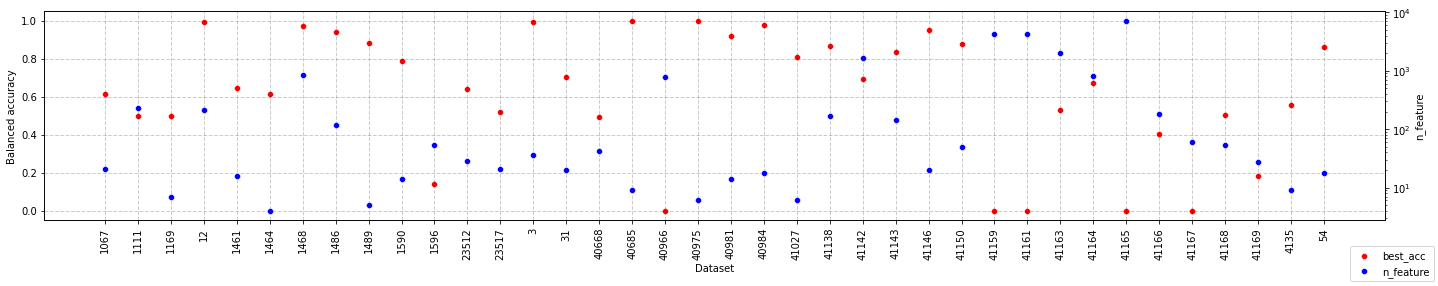

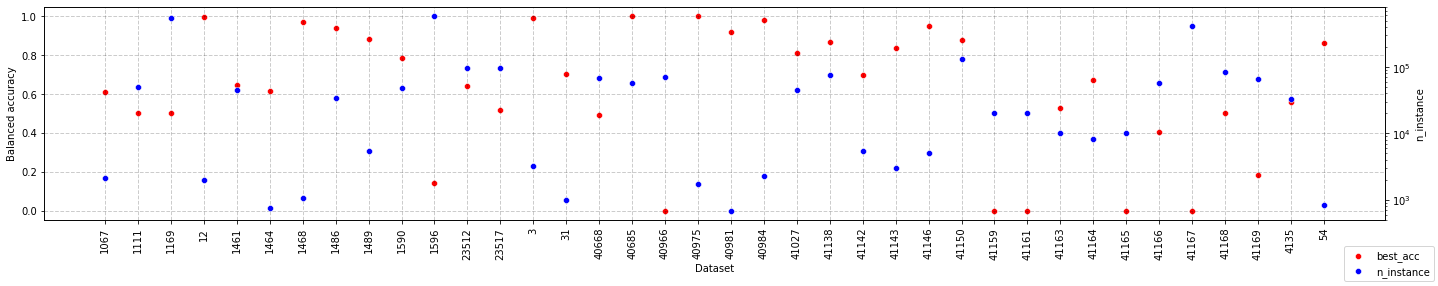

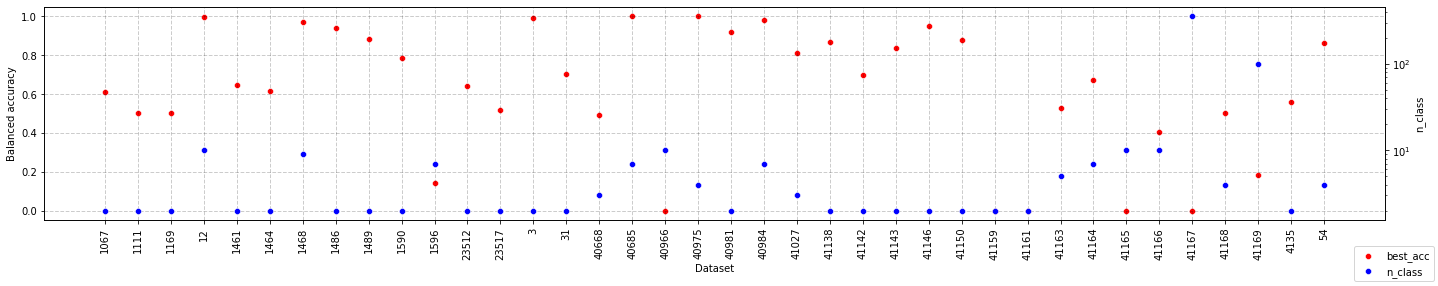

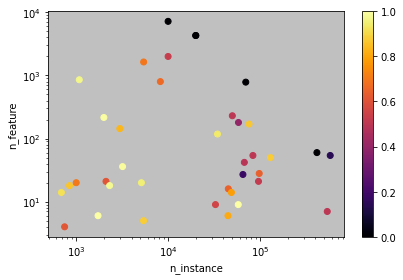

In [ ]:
res_df = results_df

y1, y2 = 'best_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'best_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'best_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

In [ ]:
# Not used

# Plot test acc distribution on each dataset
fig, ax = plt.subplots(figsize=(20,8))
sns.violinplot(x='dataset', y='mean_acc', 
               data=res_df.sort_values('mean_acc'), 
               ax=ax)

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Dataset')
ax.set_ylabel('Balanced accuracy')

ax.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

fig.tight_layout()

fig_name = 'res_plot_' + fname + '.png'
#fig.savefig(fig_name)

# Wilcoxon signed-rank test
To test the null hypothesis that there is no difference between two set of values, we can apply the two-sided test.

In [ ]:
# Filter out results on same dataset in two differnt run
datasets_to_compare = np.intersect1d(res1_df['dataset'], res2_df['dataset'])
# Construct result table
compare_res_df = res1_df[['dataset', 'mean_acc', 'sd_acc']].merge(
    res2_df[['dataset', 'mean_acc', 'sd_acc']], 
    on='dataset', how='inner',
    suffixes=('_exp1', '_exp2'))
# Compute difference
compare_res_df['improvement'] = compare_res_df['mean_acc_exp2'] - compare_res_df['mean_acc_exp1']
# Compute p-values for Wilcoxon signed-rank test
pvals = {dataset: wilcoxon(res1[dataset]['acc'], 
                   res2[dataset]['acc'], 
                   alternative='two-sided')[1] for dataset in datasets_to_compare}
# Merge to result table
compare_res_df['pval_signedrank'] = compare_res_df['dataset'].map(pvals).fillna('')


NameError: ignored

In [ ]:
# Show result
compare_res_df

,dataset,mean_acc_exp1,sd_acc_exp1,mean_acc_exp2,sd_acc_exp2,improvement,pval_signedrank
0,1468,0.951517,0.010539,0.709182,0.301034,-0.242335,0.062500
1,12,0.979841,0.006431,0.985477,0.003484,0.005637,0.312500
2,41143,0.798071,0.002982,0.829970,0.002243,0.031899,0.062500
3,3,0.985300,0.001506,0.986602,0.001189,0.001302,0.108809
4,41146,0.943067,0.003071,0.946819,0.002472,0.003751,0.125000
5,40984,0.981813,0.002698,0.977665,0.001179,-0.004147,0.067889
6,54,0.813181,0.019257,0.834590,0.021481,0.021409,0.125000
7,40981,0.899937,0.005826,0.908641,0.005958,0.008704,0.062500
8,40975,0.985431,0.006899,0.999438,0.001124,0.014007,0.062500
9,1489,0.868555,0.018134,0.874925,0.003547,0.006370,0.812500
